# Evaluating Sequential Data

This is a quick example to show how to use the evaluation metrics in this library on your synthetic data.

Our current repo is still very much work-in-progress, so you may run into some errors. Also, there will likely be some significant changes to the code structure in the future.

# Environment

## Library Imports

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
from itertools import product
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Jupyter-specific Imports and Settings

In [4]:
# set printing options
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')
from importlib import reload

## Import local libraries

In [43]:
from synthesis.evaluation.metrics import JSDistanceColumns
from synthesis.evaluation._base import BaseMetric, BasePredictiveMetric
from synthesis.evaluation.evaluator import SyntheticEvaluator, DEFAULT_METRICS

In [6]:
os.getcwd()

'c:\\projects\\synthetic_data_generation\\examples\\tutorials'

# Load and Preprocess datasets

Load the original and synthetic datasets you created. 

In [22]:
df_original = pd.read_csv('../data/original/adult.csv')
df_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
df_synth = pd.read_csv('../data/synthetic/adult_pb_1eps.csv')
df_synth.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,19,State-gov,344804,Bachelors,10,Divorced,Other-service,Not-in-family,White,Female,0,0,72,United-States,<=50K
1,24,Private,37314,Some-college,14,Never-married,Craft-repair,Not-in-family,White,Male,0,0,20,United-States,<=50K
2,29,Private,249078,Some-college,13,Separated,Adm-clerical,Unmarried,White,Female,99999,0,70,United-States,<=50K
3,18,Private,256173,9th,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,38,Self-emp-not-inc,242984,Some-college,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1974,50,United-States,>50K


# Evaluate

For evaluating a synthetic dataset to an original, e can run metrics individually by fitting them on the original and synthetic data. 

Subsequently we can run score and plot (if implemented).

{'age': 0.10666635610710967,
 'workclass': 0.08774993470405375,
 'fnlwgt': 0.5838199278590301,
 'education': 0.05043840536422243,
 'education-num': 0.01842760971623825,
 'marital-status': 0.053531842199113916,
 'occupation': 0.02623747532811313,
 'relationship': 0.004223315441285426,
 'race': 0.04557429828403815,
 'sex': 0.0011532258871775494,
 'capital-gain': 0.15145646613154667,
 'capital-loss': 0.1494556585457859,
 'hours-per-week': 0.13004526016378382,
 'native-country': 0.09782753957213051,
 'income': 0.0008627862092529555}

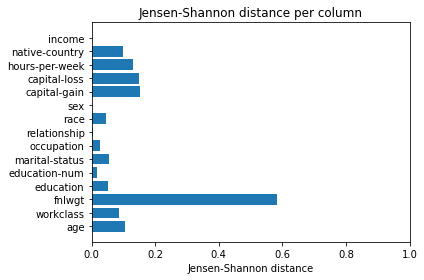

In [59]:
js_distance_columns = JSDistanceColumns().fit(df_original, df_synth)
js_distance_columns.score()
js_distance_columns.plot()

Or we can fit multiple metrics at the same time using the SyntheticEvaluator.

In [60]:
synth_eval = SyntheticEvaluator()
synth_eval.fit(df_original, df_synth)

After fitting you can use the score and plotting functions to see the results.

In [61]:
synth_eval.score()

{'js_distance_columns': {'age': 0.10666635610710967,
  'workclass': 0.08774993470405375,
  'fnlwgt': 0.5838199278590301,
  'education': 0.05043840536422243,
  'education-num': 0.01842760971623825,
  'marital-status': 0.053531842199113916,
  'occupation': 0.02623747532811313,
  'relationship': 0.004223315441285426,
  'race': 0.04557429828403815,
  'sex': 0.0011532258871775494,
  'capital-gain': 0.15145646613154667,
  'capital-loss': 0.1494556585457859,
  'hours-per-week': 0.13004526016378382,
  'native-country': 0.09782753957213051,
  'income': 0.0008627862092529555},
 'js_distance_average': 0.10049800676752546,
 'associations': 2.0212790572602137}

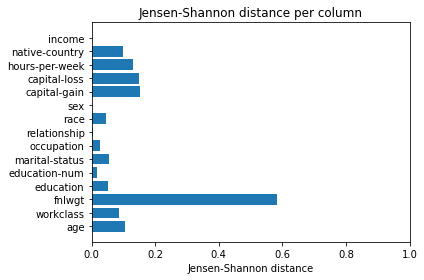

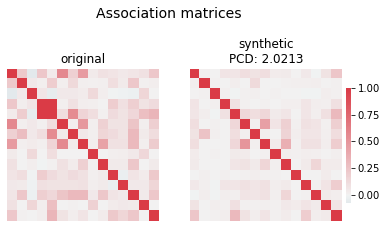

In [62]:
synth_eval.plot()

SyntheticEvaluator uses the following default metrics. 

In [63]:
DEFAULT_METRICS

{'js_distance_columns': <synthesis.evaluation.metrics.JSDistanceColumns at 0x14d93318130>,
 'js_distance_average': <synthesis.evaluation.metrics.JSDistanceAverage at 0x14d93318fd0>,
 'associations': <synthesis.evaluation.metrics.Associations at 0x14d93318520>}

You can remove or add additional metrics and specify these at initialisation using a dictionary as seen below.

Custom metrics should inherent from synthesis.evaluation._base.BaseMetric and should have at least have a fit and score function (plot is optional).

In [64]:
class CustomMetric(BaseMetric):
    """Example metric that checks whether both dataset have same length"""

    def fit(self, data_original, data_synthetic):
        self.stats_original_ = data_original.shape[0]
        self.stats_synthetic_ = data_synthetic.shape[0]
    
    def score(self):
        return self.stats_original_ == self.stats_synthetic_
    
    def plot(self):
        pass

In [65]:
custom_metrics = {
    'same_length': CustomMetric(),
    'js_distance_columns': JSDistanceColumns()
}

In [66]:
se_custom = SyntheticEvaluator(metrics=custom_metrics)
se_custom.fit(df_original, df_synth)

{'same_length': True,
 'js_distance_columns': {'age': 0.10666635610710967,
  'workclass': 0.08774993470405375,
  'fnlwgt': 0.5838199278590301,
  'education': 0.05043840536422243,
  'education-num': 0.01842760971623825,
  'marital-status': 0.053531842199113916,
  'occupation': 0.02623747532811313,
  'relationship': 0.004223315441285426,
  'race': 0.04557429828403815,
  'sex': 0.0011532258871775494,
  'capital-gain': 0.15145646613154667,
  'capital-loss': 0.1494556585457859,
  'hours-per-week': 0.13004526016378382,
  'native-country': 0.09782753957213051,
  'income': 0.0008627862092529555}}

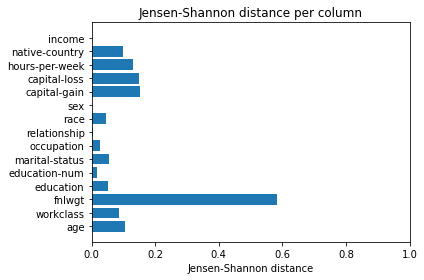

In [67]:
se_custom.score()
se_custom.plot()